# RandomForest with missing values

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

In [ ]:
if True: 

    idx_train = list(df_X.isna().any(axis=1))
    idx_test = list(~df_X.isna().any(axis=1))

    set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
    intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

    for i, bool_test in enumerate(idx_test): 
        if intersect_rid_idx.iloc[i] & bool_test:
            idx_test[i] = False
            idx_train[i] = True

    df_X_train = df_X.loc[idx_train]
    df_X_test = df_X.loc[idx_test]

    df_y_train = df_y.loc[idx_train]
    df_y_test = df_y.loc[idx_test]

    c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
    c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

    continuous_model = SimpleImputer(strategy="constant", fill_value=-1)
    name_continuous_imputer  = "KNNImputer"
    ordinal_model = SimpleImputer(strategy="constant", fill_value=-1)
    name_ordinal_imputer = "SimpleImputer_constant"
    rf_miss = RandomForestRegressor()
    name_model = "RandomForestRegressor"

    ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']

    continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

    # Separate imputers for ordinal and continuous data
    print("Using separate imputers for ordinal and continuous data.")

    df_X_train = df_X_train.copy()
    df_X_test = df_X_test.copy()

    # Continuous Imputation Transformer (Example: SimpleImputer)
    continuous_imputer = Pipeline([
        (name_continuous_imputer, continuous_model),
    ])

    # Ordinal Imputation Transformer (Example: KNN Imputer)
    ordinal_imputer = Pipeline([
        (name_ordinal_imputer, ordinal_model)
    ])

    # Create a ColumnTransformer to apply the appropriate imputer to each type of variable
    preprocessor = ColumnTransformer(
        transformers=[
            ('ordinal', ordinal_imputer, ordinal_features),
            ('continuous', continuous_imputer, continuous_features)
        ],
        remainder='passthrough'
    )

    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])

        # Separate imputers for ordinal and continuous data

    # Fit and transform, then convert back to DataFrame with original column names
    start = time.time()
    pipeline.fit(df_X_train)
    end = time.time()

    impute_model_time = end - start

    X_train_imputed = pipeline.transform(df_X_train)
    df_X_train_imputed = df_X_train.copy()
    df_X_train_imputed[ordinal_features+continuous_features] = X_train_imputed

    # Transform the test set
    if df_X_test.isna().any().any(): 
        X_test_imputed = pipeline.transform(df_X_test)
        df_X_test_imputed = df_X_test.copy()
        df_X_test_imputed[ordinal_features+continuous_features] = X_test_imputed
    else : 
        print("No NaN in test data -> Keep as it is. ")
        df_X_test_imputed = df_X_test

    #df_X_train_imputed[ordinal_features] = df_X_train_imputed[ordinal_features].astype("category")
    #df_X_test_imputed[ordinal_features] = df_X_test_imputed[ordinal_features].astype("category")

    # Demographics adjustment for y
    demographic_adjustment_y = DemographicAdjustmentTransformer()

    y_train_adjusted = demographic_adjustment_y.fit_transform(df_y_train, c_train)
    y_test_adjusted = demographic_adjustment_y.transform(df_y_test, c_test)

    # Demographics adjustment for X
    demographic_adjustment_X = DemographicAdjustmentTransformer(categorical_columns=ordinal_features)
    X_train_adjusted = demographic_adjustment_X.fit_transform(df_X_train_imputed, c_train)
    X_test_adjusted = demographic_adjustment_X.transform(df_X_test_imputed, c_test)


Using separate imputers for ordinal and continuous data.
No NaN in test data -> Keep as it is. 


In [ ]:
X_train_adjusted = X_train_adjusted.where(~df_X[idx_train].isna(), np.NaN)

In [ ]:
X_train_adjusted

,ARG1,ATP8B5P || ZFAND6,C17ORF103,C6ORF25,CLU,CORO2B,CTNNB1,DACT1,ELOVL5,FOLR3,...,LH_Default_pCunPCC_1_Cortical,RH_Default_PFCdPFCm_6_Cortical,LH_Default_pCunPCC_2_Cortical,RH_Default_PFCdPFCm_7_Cortical,LH_Default_pCunPCC_3_Cortical,RH_Default_pCunPCC_1_Cortical,LH_Default_pCunPCC_4_Cortical,RH_Default_pCunPCC_2_Cortical,LH_Default_PHC_1_Cortical,RH_Default_pCunPCC_3_Cortical
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.389655,-0.040790,-0.271971,0.294253,-0.061533,-0.286726,0.026562,-0.038726,-0.452943,-0.064496
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.403616,-0.045332,-0.315993,0.229454,0.006813,-0.250549,-0.006506,0.001022,-0.408909,-0.099253
13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.463824,-0.042736,-0.353135,0.287193,-0.061844,-0.318497,-0.098260,-0.073555,-0.569484,-0.151474
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005985,0.330994,0.139899,0.159765,0.046671,0.210719,-0.054675,0.145579,-0.044845,-0.028604
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.087073,0.217378,0.098715,0.032554,0.008957,0.122995,-0.076380,0.022226,-0.171763,-0.114565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.296475,-0.196589,0.112932,-0.104081,-0.037671,0.200198,0.090658,0.073010,0.090452,0.079836
9573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.069607,-0.251217,-0.051187,-0.247316,0.036547,-0.017243,0.092161,0.048579,-0.120701,0.151930
9595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.317184,-0.013228,0.226503,-0.121663,0.000017,0.509128,-0.078021,0.187816,0.204026,0.181615
9611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.168955,-0.016848,0.190652,0.085978,-0.133788,0.451700,0.266698,0.263875,0.086667,0.339551


In [ ]:
if True: 

    # Perform prediction and save variables
    start = time.time()
    rf_miss.fit(X_train_adjusted, y_train_adjusted) 
    end = time.time()

    predict_model_time = end - start

    y_pred_adjusted = rf_miss.predict(X_test_adjusted)

    y_pred_adjusted = pd.DataFrame(y_pred_adjusted, columns=y_test_adjusted.columns)

    # Metrics computed in original space
    y_pred = demographic_adjustment_y.inverse_transform(y_pred_adjusted, c_test)

    params = {
        "ordinal_imputer": name_ordinal_imputer, 
        "continuous_imputer": name_continuous_imputer, 
        "model": name_model, "train_shape" : X_train_adjusted.shape, 
        "test_shape": X_test_adjusted.shape
    }

    def compute_all_metrics(y_test, y_pred): 
        # Metrics computed in adjusted space
        mse_score = mean_squared_error(y_test, y_pred, multioutput="raw_values")
        mae_score = mean_absolute_error(y_test, y_pred, multioutput="raw_values")
        r2 = r2_score(y_test,y_pred, multioutput="raw_values")
        explained_variance = explained_variance_score(y_test, y_pred, multioutput="raw_values")

        try: 
            corr_p = correlation(y_pred, y_test)
        except: 
            print("Problem when computing correlation!")
            if type(y_test) != type(y_pred): 
                print("Type of inputs is different.")
                corr_p = None
            else : 
                corr_p = pearsonr(y_test, y_pred)

        return mse_score, mae_score, r2, explained_variance, corr_p

    if df_X_test.shape[0] != 1: 

        # Metrics computed in adjusted space
        mse_score_adj, mae_score_ajd, r2_adj, explained_variance_adj, corr_adj = compute_all_metrics(y_test_adjusted.values, y_pred_adjusted.values)

        results_adj = {
            "mse_score": mse_score_adj, 
            "mae_score":mae_score_ajd, 
            "r2":r2_adj, 
            "explained_variance":explained_variance_adj, 
            "corr":corr_adj, 
        }

        mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(df_y_test.values, y_pred.values)

        results_org = {
            "mse_score": mse_score, 
            "mae_score": mae_score, 
            "r2": r2, 
            "explained_variance": explained_variance, 
            "corr": corr, 
        }

    else : 
        print("Saving predictions in dict!")
        results_adj = {
            "y_pred": y_pred_adjusted.values, 
            "y_test": y_test_adjusted.values,
        }

        results_org = {
            "y_pred": y_pred.values, 
            "y_test": df_y_test.values,
        }


    dict_results = {
        "params": params, 
        "imputation_time": impute_model_time,
        "fitting_time": predict_model_time, 
        "results_adj": results_adj, 
        "results_org": results_org
        }


Problem when computing correlation!
Problem when computing correlation!


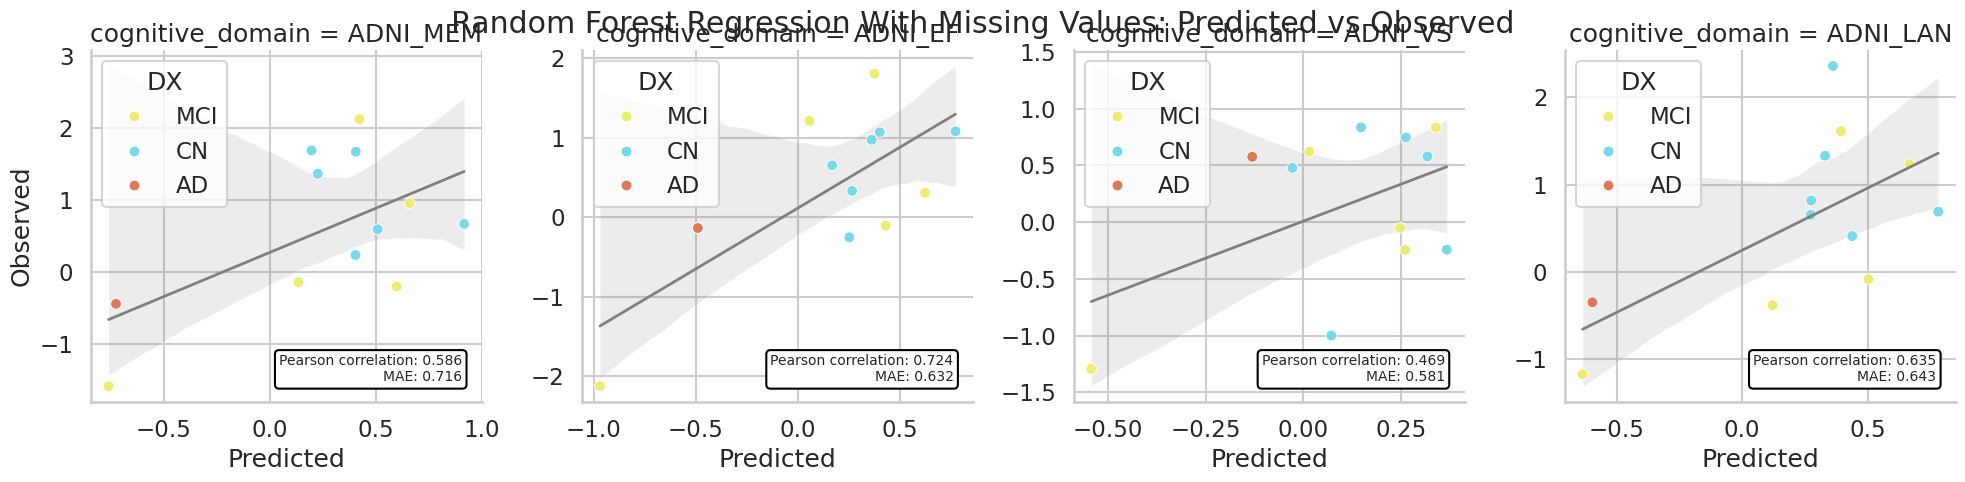

In [ ]:
df_y_pred_ajd = pd.concat([df_all[idx_test][["DX", "RID"]].reset_index(drop=True), y_pred_adjusted],axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_pred")
df_y_test_ajd = pd.concat([df_all[idx_test][["DX", "RID"]], y_test_adjusted], axis=1).melt(id_vars=["RID", "DX"], var_name="cognitive_domain", value_name="y_test")

# Assuming `merged_df` is already prepared and dx_palette is defined
merged_df = pd.merge(df_y_pred_ajd, df_y_test_ajd)

sns.set_style("whitegrid")

# Create the lmplot with only the regression line
g = sns.lmplot(
    data=merged_df,
    x="y_pred",
    y="y_test",
    col="cognitive_domain",
    sharex=False,
    sharey=False,
    scatter=False,  # Remove scatter points
    line_kws={"color": "grey", "lw": 2}  # Customize regression line
)

# Extract the order of cognitive domains from the lmplot
cognitive_domains_order = g.col_names

# Overlay scatter points colored by 'DX' and add annotations
for ax, cognitive_domain in zip(g.axes.flat, cognitive_domains_order):
    group_data = merged_df[merged_df["cognitive_domain"] == cognitive_domain]
    
    # Scatterplot
    sns.scatterplot(
        data=group_data,
        x="y_pred",
        y="y_test",
        hue="DX",
        palette=dx_palette,
        ax=ax,
        s=60
    )
    
    # Calculate Pearson correlation and MAE
    correlation = group_data["y_pred"].corr(group_data["y_test"])
    mae = mean_absolute_error(group_data["y_test"], group_data["y_pred"])
    
    # Add text annotation in the lower right corner
    ax.text(
        0.95, 0.05,  # Position in axes coordinates
        f"Pearson correlation: {correlation:.3f}\nMAE: {mae:.3f}",
        transform=ax.transAxes,
        ha="right", va="bottom",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
    )

# Adjust layout and title
g.set_axis_labels("Predicted", "Observed")
g.fig.subplots_adjust(top=0.9)  # Adjust the top for title space
g.fig.suptitle("Random Forest Regression With Missing Values: Predicted vs Observed")  # Add a title

plt.show()


#### Model specific importance values

In [ ]:
n_features = 20

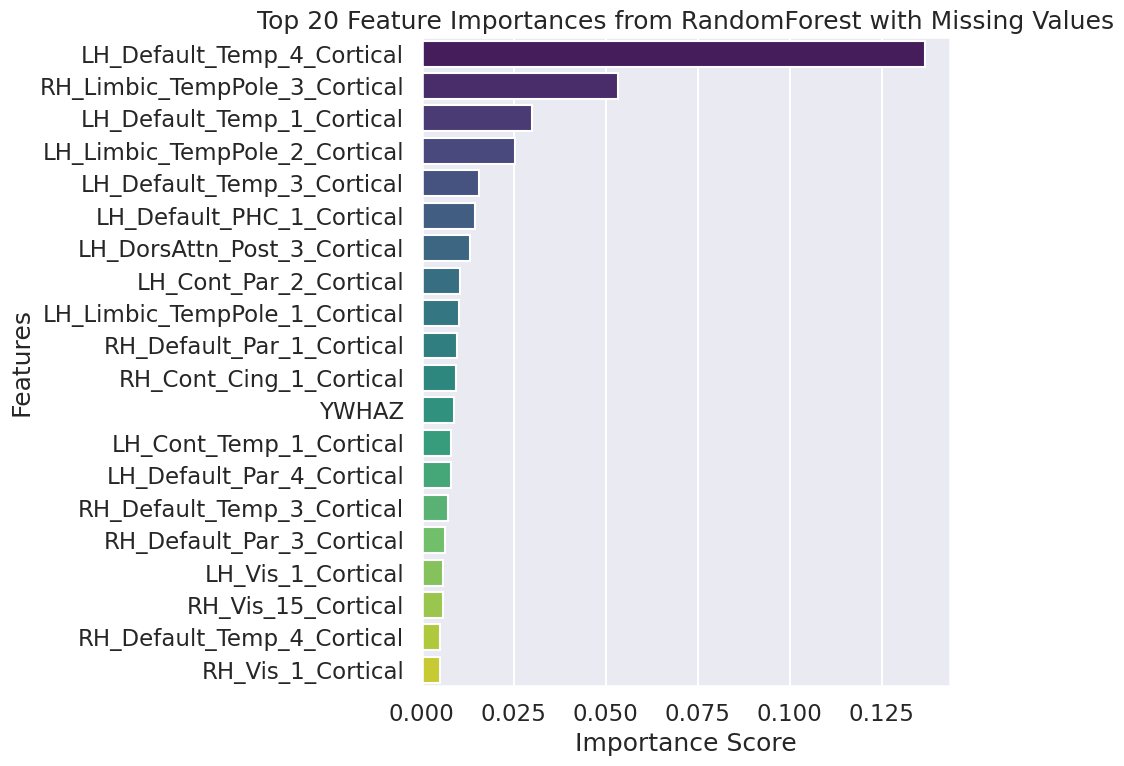

In [ ]:
sns.set_style("darkgrid")

# Extract feature importances
feature_importances = rf_miss.feature_importances_

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    "Feature": df_X_train.columns,  # Assuming your training data has column names
    "Importance": feature_importances
})

# Sort by importance and take the top 20
top_features_df = features_df.sort_values(by="Importance", ascending=False).head(n_features)

# Plot the top 20 feature importances using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(data=top_features_df, x="Importance", y="Feature", palette="viridis")
plt.title(f"Top {n_features} Feature Importances from RandomForest with Missing Values")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

#### Permutation importance values

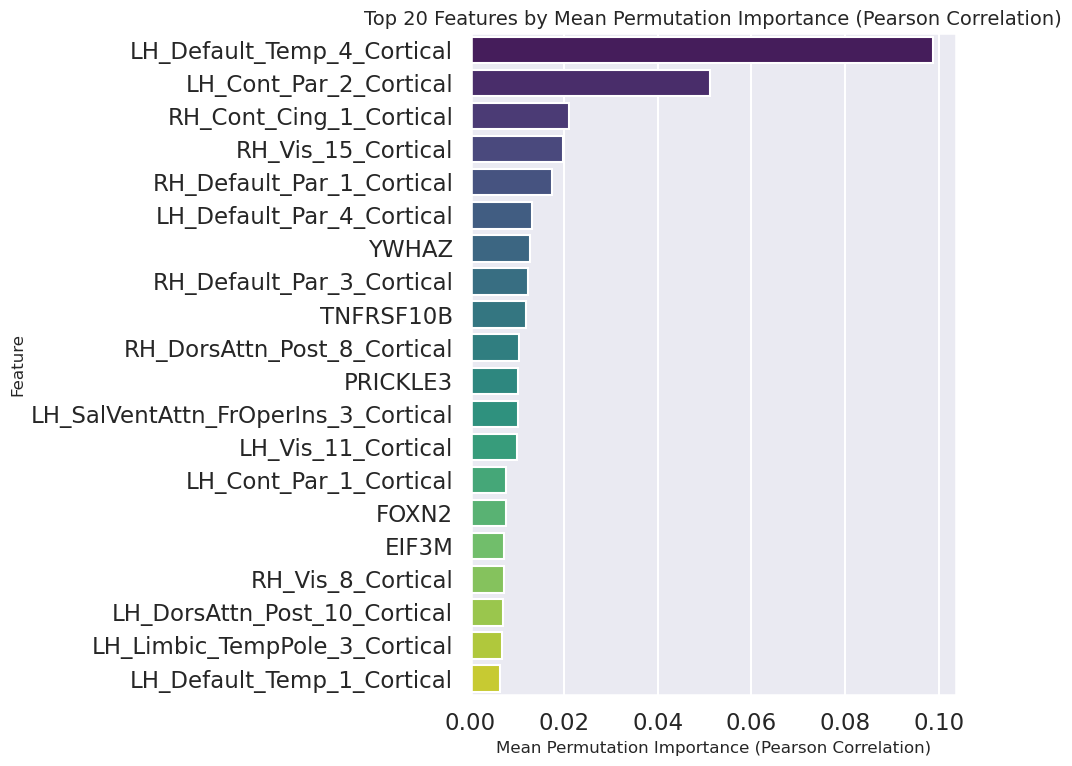

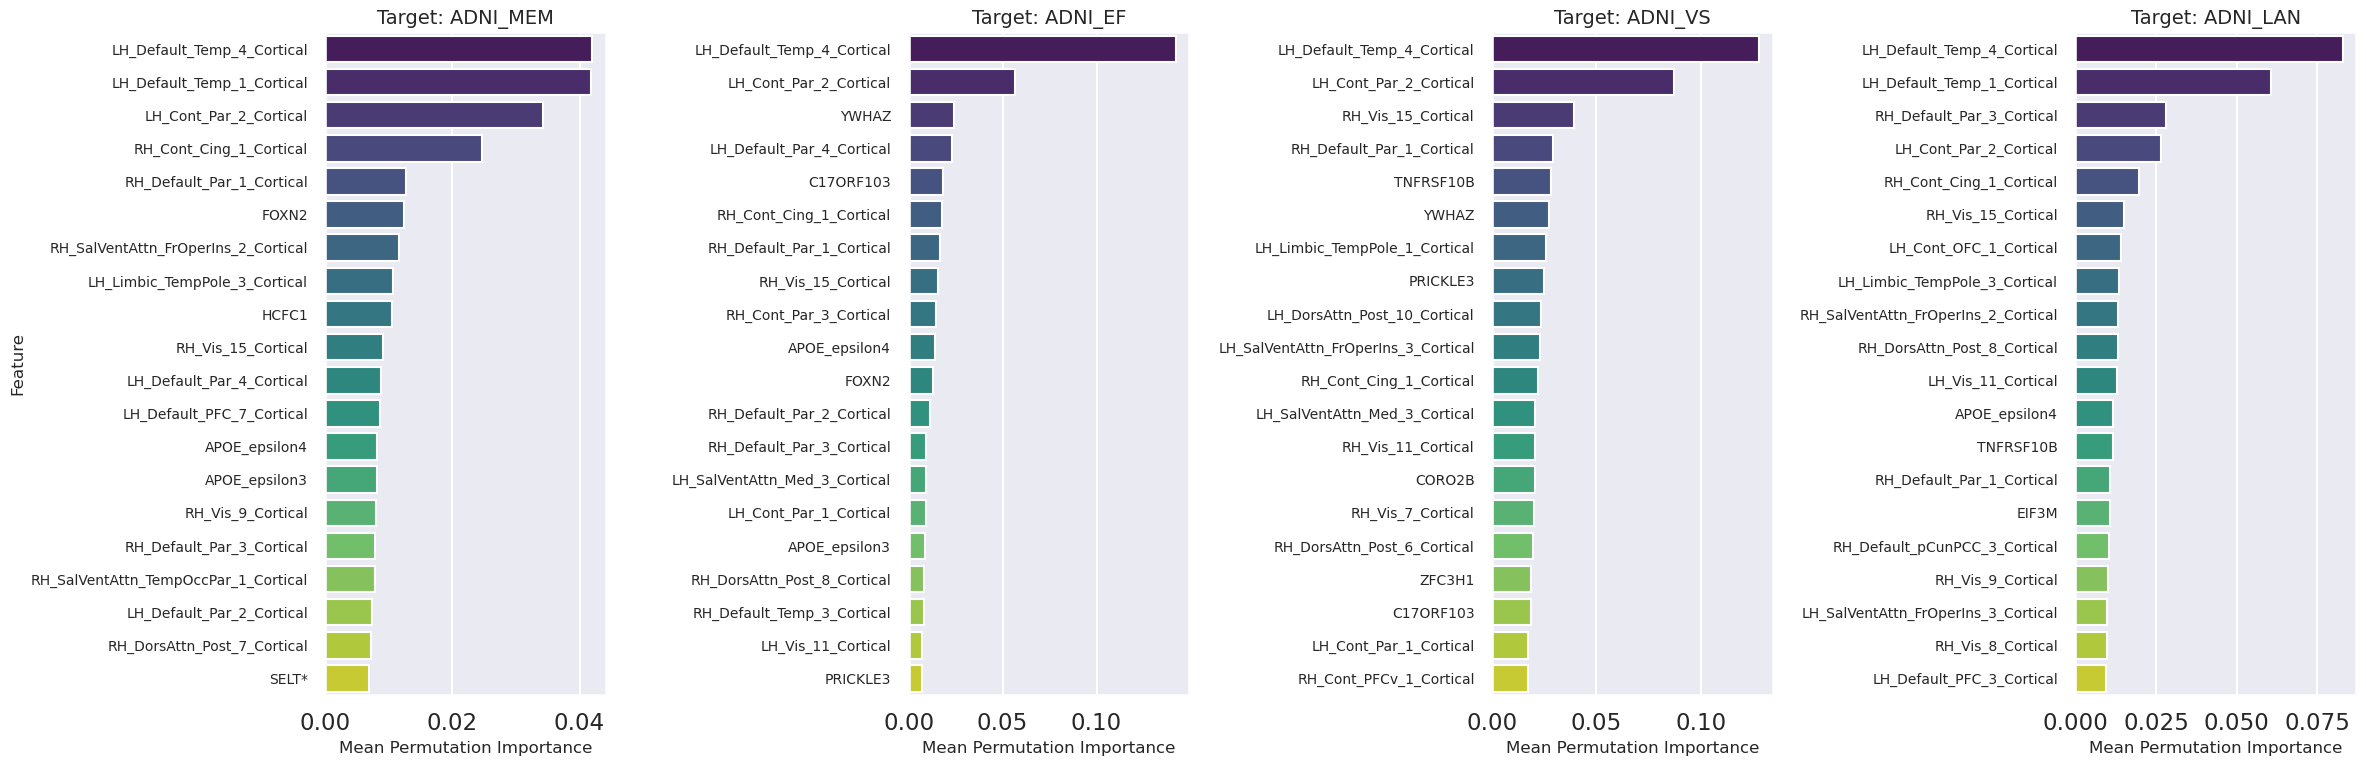

In [ ]:
X_test = X_test_adjusted
X_train = X_train_adjusted
Y_test = y_test_adjusted

model = rf_miss

# Compute permutation importance with Pearson correlation as the scoring metric
result = permutation_importance(
    model, X_test, Y_test, scoring=pearson_scorer, n_repeats=10, random_state=42
)

# Step 1: Extract importance for each target
permutation_results = {}
for i, target in enumerate(Y_test.columns):
    permutation_results[target] = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": result.importances_mean[:, i]  # Extract importance for this target
    }).sort_values(by="Importance", ascending=False)

# Step 2: Mean importance across targets
mean_importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": result.importances_mean.mean(axis=1)  # Mean importance across targets
}).sort_values(by="Importance", ascending=False)


# # Step 4: Plot for each target
# for target in permutation_results:
#     plot_importance(
#         permutation_results[target], title=f"Top 40 Features for Target: {target}"
#     )

# Step 5: Plot for top mean importances across all targets
plot_importance(mean_importance, title=f"Top {n_features} Features by Mean Permutation Importance (Pearson Correlation)", top_n=n_features)

# Number of targets
num_targets = len(Y_test.columns)

# Set up subplots
fig, axes = plt.subplots(1, num_targets, figsize=(6 * num_targets, 8), sharey=False)

# Iterate over each target and corresponding axis
for i, (target, ax) in enumerate(zip(permutation_results.keys(), axes)):
    # Select the top 40 features for the current target
    importances = permutation_results[target].head(n_features)
    
    # Create the barplot on the current axis
    sns.barplot(
        x="Importance", y="Feature", data=importances, ax=ax, palette="viridis", orient="h",
    )
    ax.set_title(f"Target: {target}", fontsize=14)
    ax.set_xlabel("Mean Permutation Importance", fontsize=12)
    if i == 0:  # Only show the y-axis label on the first plot
        ax.set_ylabel("Feature", fontsize=12)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='y', labelsize=10)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()

#### Shapeley values

  0%|          | 0/12 [00:00<?, ?it/s]

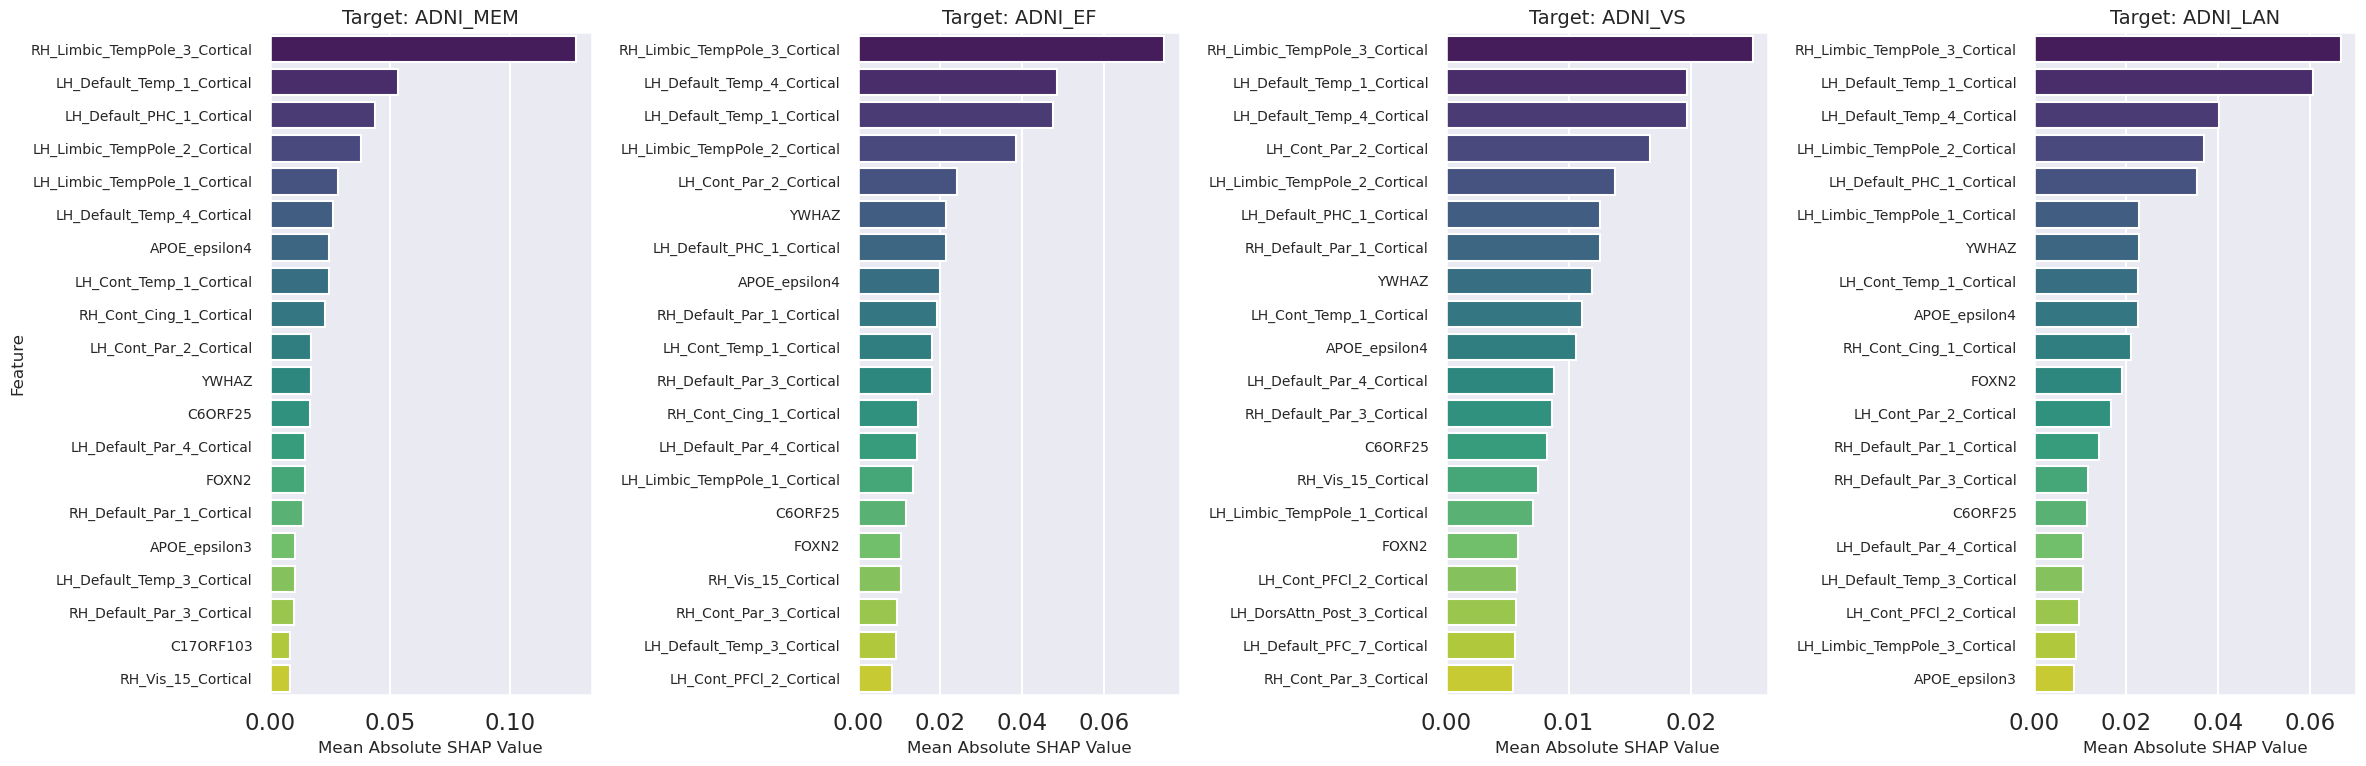

In [ ]:
# Step 1: Initialize the SHAP Explainer and Compute SHAP Values
explainer = shap.KernelExplainer(model.predict, X_test)
shap_values = explainer(X_test)  # SHAP values for all targets

# Step 2: Extract SHAP values for each target
shap_results = {}
for i, target in enumerate(Y_test.columns):
    # Extract SHAP values for the current target
    shap_target_values = shap_values.values[:, :, i]
    
    # Compute mean absolute SHAP values per feature
    mean_abs_shap = pd.DataFrame({
        "Feature": X_test.columns,
        "Importance": abs(shap_target_values).mean(axis=0)
    }).sort_values(by="Importance", ascending=False)
    
    # Store the result
    shap_results[target] = mean_abs_shap

# Step 3: Plot top features for each target as subplots
num_targets = len(Y_test.columns)
fig, axes = plt.subplots(1, num_targets, figsize=(6 * num_targets, 8), sharey=False)

for i, (target, ax) in enumerate(zip(shap_results.keys(), axes)):
    # Select the top 40 features for the current target
    importances = shap_results[target].head(n_features)
    
    # Create the barplot on the current axis
    sns.barplot(
        x="Importance", y="Feature", data=importances, ax=ax, palette="viridis", orient="h"
    )
    ax.set_title(f"Target: {target}", fontsize=14)
    ax.set_xlabel("Mean Absolute SHAP Value", fontsize=12)
    if i == 0:  # Only show the y-axis label on the first plot
        ax.set_ylabel("Feature", fontsize=12)
    else:
        ax.set_ylabel("")
    ax.tick_params(axis='y', labelsize=10)

# Adjust layout for better appearance
plt.tight_layout()
plt.show()


SHAP Summary for Target: ADNI_MEM


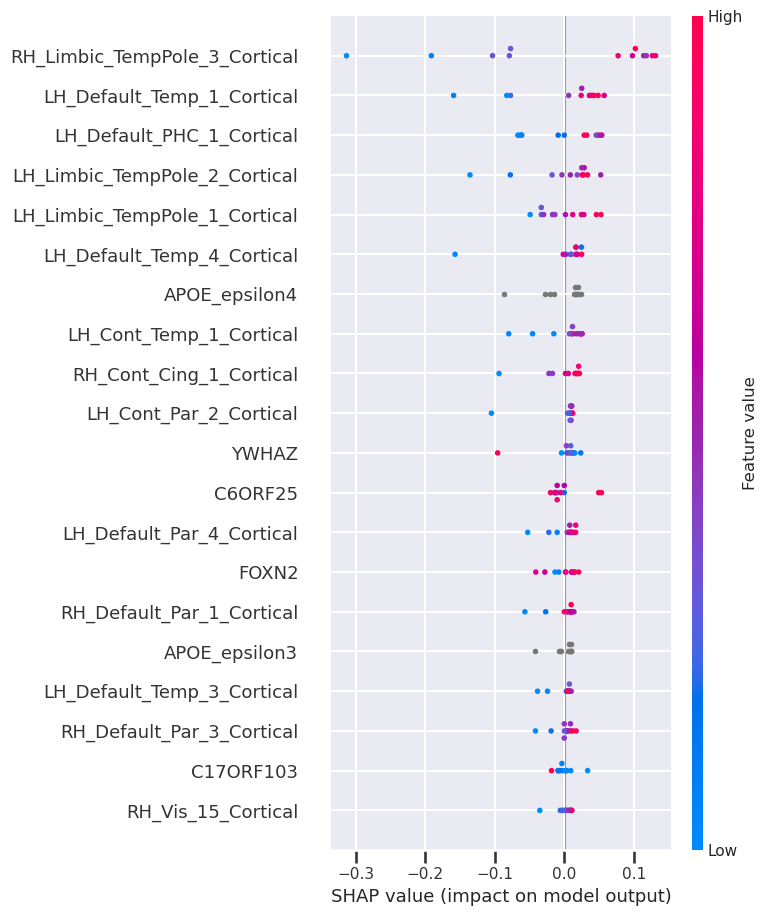

SHAP Summary for Target: ADNI_EF


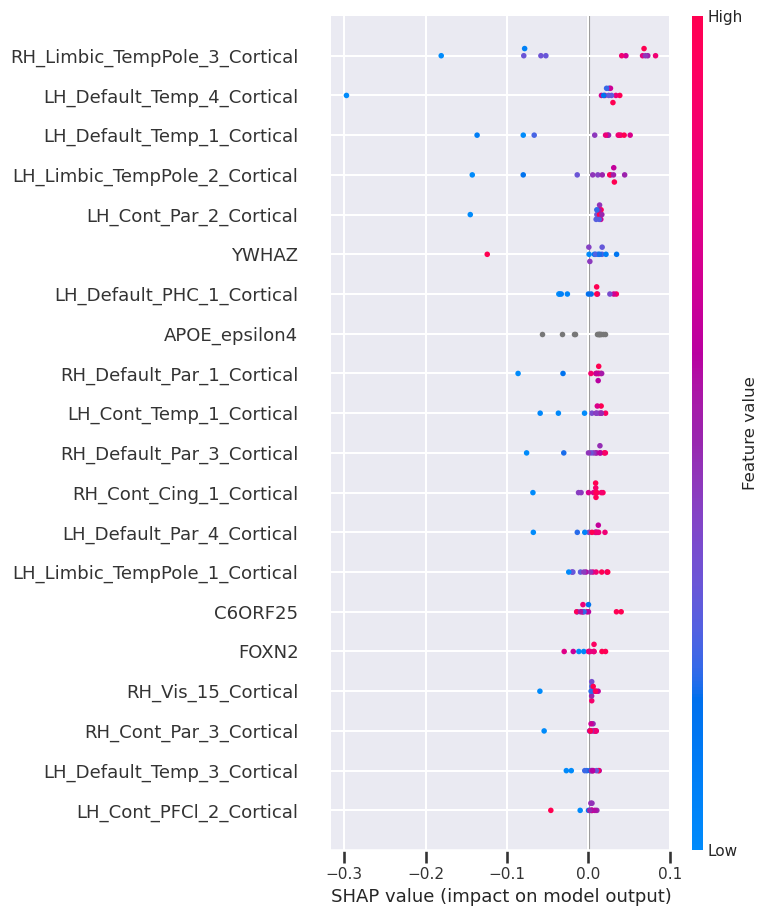

SHAP Summary for Target: ADNI_VS


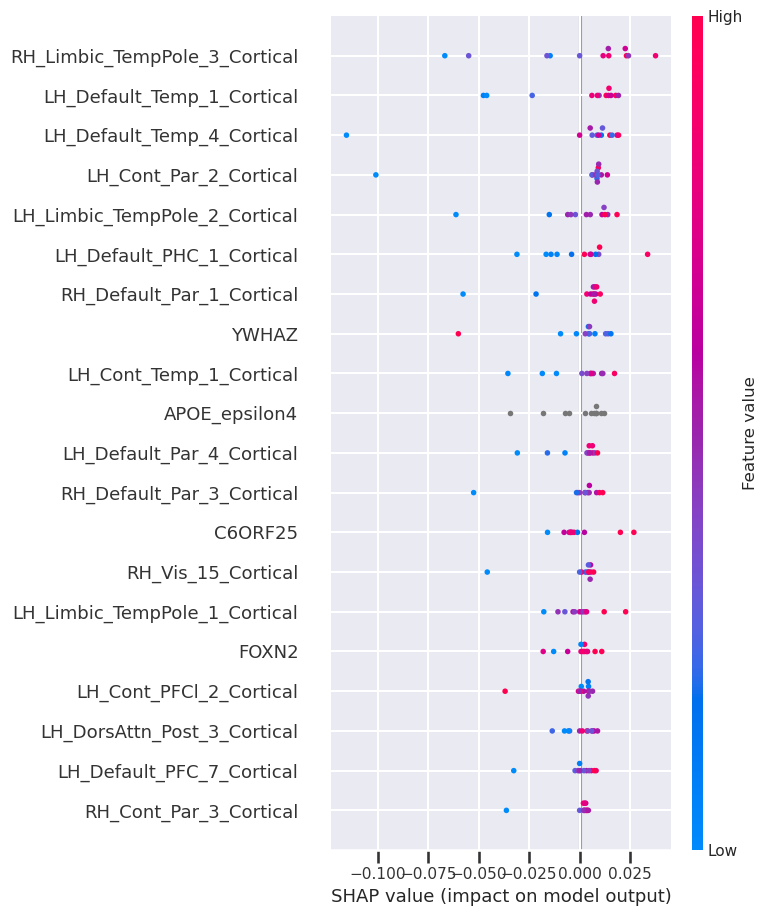

SHAP Summary for Target: ADNI_LAN


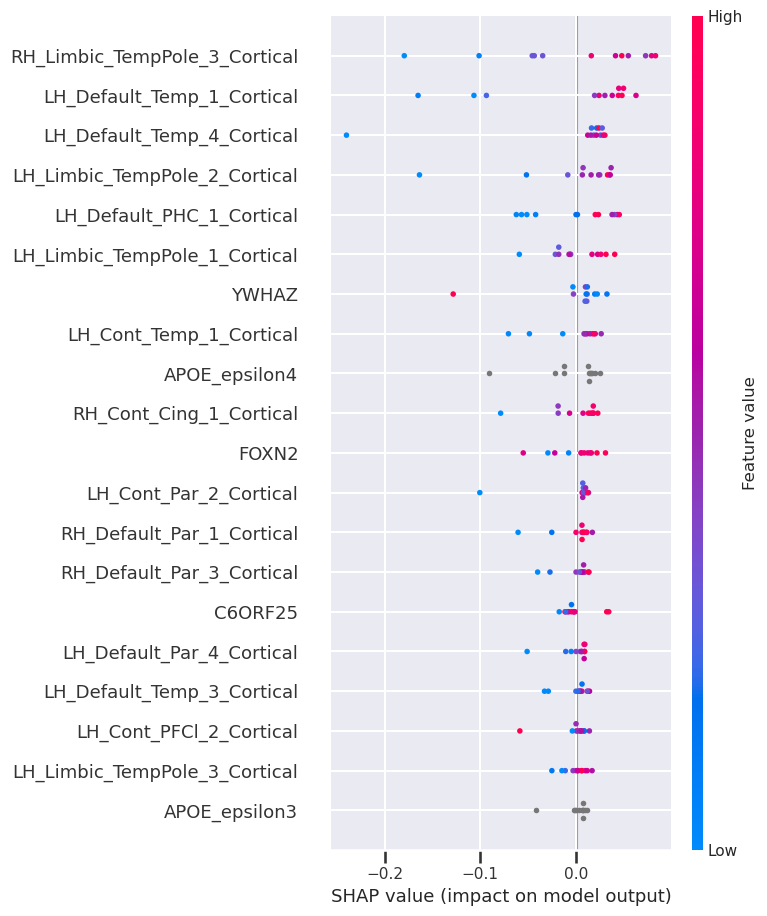

In [ ]:
# Step 2: Plot SHAP Summary for Each Target
for i, target in enumerate(Y_test.columns):
    print(f"SHAP Summary for Target: {target}")
    shap.summary_plot(shap_values.values[:, :, i], X_test, feature_names=X_test.columns, max_display=n_features)